# Imports

In [1]:
import main
import matplotlib.pyplot as plt
import numpy as np
import seeder_realistic
from pathlib import Path
from pandas import DataFrame, read_csv
from enum import IntEnum

plt.style.use("seaborn-v0_8-notebook")

In [2]:
def analyze_given_packages(packages: DataFrame, title: str) -> None:
    columns = ["Vikt", "Förtjänst", "Deadline"] # Columns of interest
    _, axes = plt.subplots(1, 3, figsize=(14, 4))  # Subplots with 1 row, 2 columns

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.hist(packages[column], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f"{title}: '{column}'")
        ax.set_xlabel(column)

    plt.tight_layout()
    plt.show()

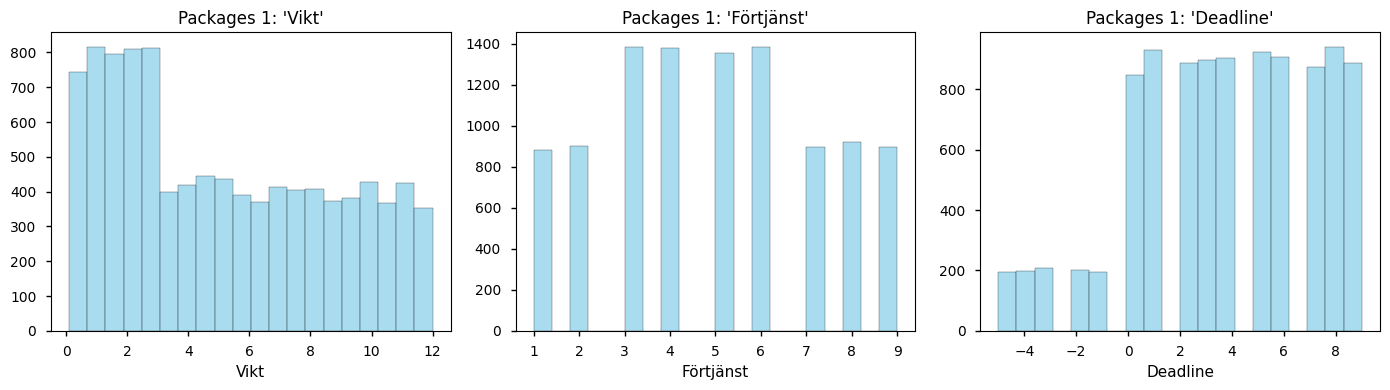

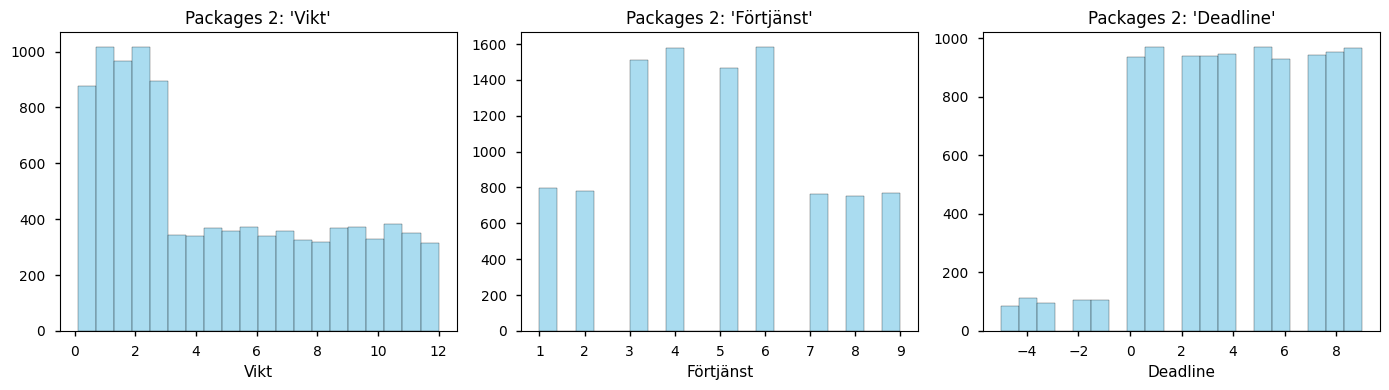

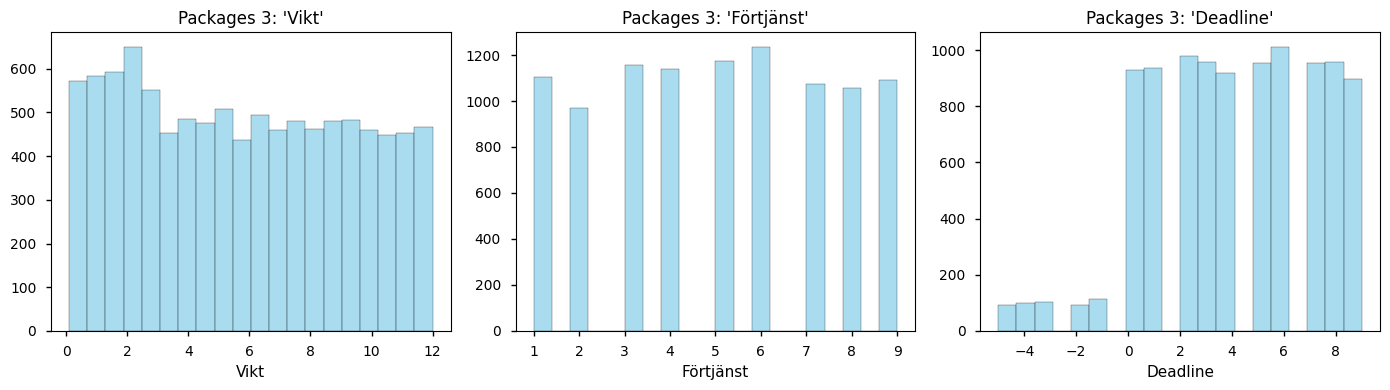

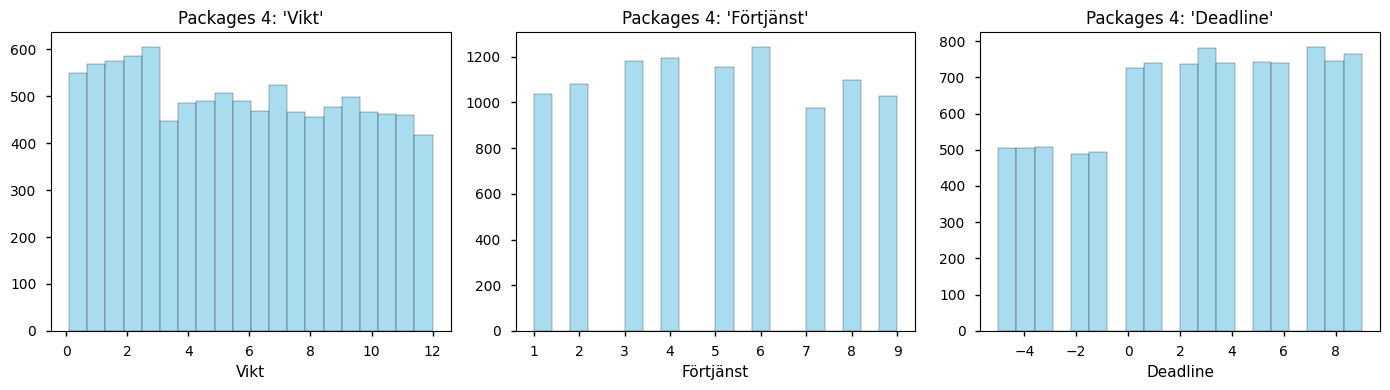

In [3]:
packages1 = read_csv("lagerstatus.csv")
packages2 = read_csv("lagerstatus2.csv")
packages3 = read_csv("lagerstatus3.csv")
packages4 = read_csv("lagerstatus4.csv")

analyze_given_packages(packages1, "Packages 1")
analyze_given_packages(packages2, "Packages 2")
analyze_given_packages(packages3, "Packages 3")
analyze_given_packages(packages4, "Packages 4")

In [4]:
N_PACKAGES = 10_000

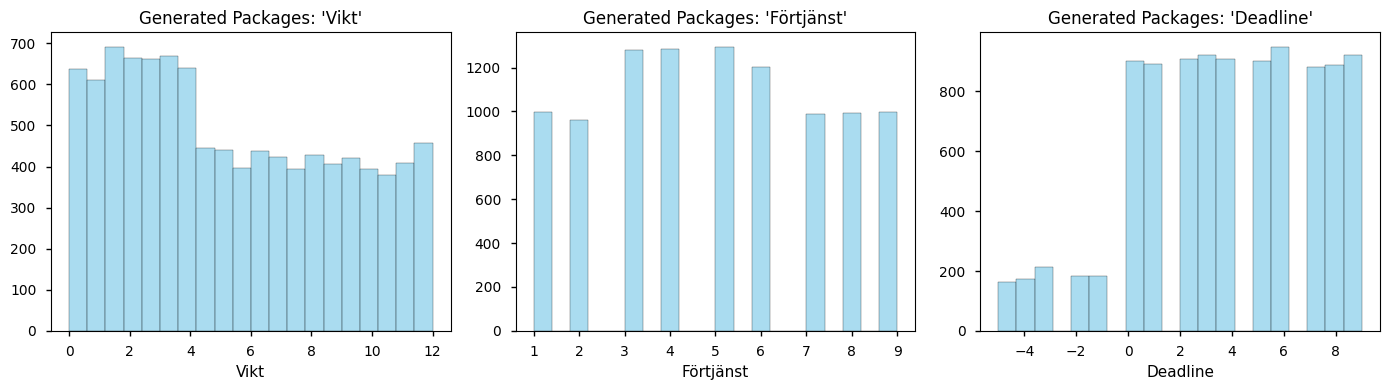

In [5]:
# Try generating similiar packages:
seeder_realistic.seed_packages(N_PACKAGES, target_path=Path("lagerstatus_seeded.csv"))
generated_packages = read_csv("lagerstatus_seeded.csv")
analyze_given_packages(generated_packages, "Generated Packages")

# Packaging and Training
Package vans for a few "days" and stop only when we think we have learned the best way to do so. Store information about every time we packaged the vans in `training_iterations`.

Note that learning can take several minutes, but since its progress is saved in a file locally it won't have to learn it all again.

In [6]:
done_learning = False

while not done_learning:
    result = main.package_vans(N_PACKAGES)
    done_learning = result["done_learning"]

print("Done learning!")

Done learning!


# Data

In [7]:
def add_profit_after_penalty_col(packages: DataFrame) -> None:
    """ Add a FörtjänstEfterStraff column """
    packages["FörtjänstEfterStraff"] = packages["Förtjänst"] - np.where( packages["Deadline"] < 0, packages["Deadline"]**2, 0 )

In [8]:
add_profit_after_penalty_col(packages1)
add_profit_after_penalty_col(packages2)
add_profit_after_penalty_col(packages3)
add_profit_after_penalty_col(packages4)

# Get Packages Function
Create a function for retrieving the packages of a selected van, or to retrieve the packages left in the warehouse.

In [9]:
class VanNumber(IntEnum):
    NOT_DELIVERED = -1
    ONE = 0
    TWO = 1
    THREE = 2
    FOUR = 3
    FIVE = 4
    SIX = 5
    SEVEN = 6
    EIGHT = 7
    NINE = 8
    TEN = 9

def get_packages(packages: DataFrame, van_number: VanNumber) -> DataFrame:
    return packages[ (packages["Delivered"] == van_number) ]

# Plot
Plot stuff for each van + the packages still left.

In [10]:
def plot_packages(packages: DataFrame, title: str) -> None:
    columns = ["Vikt", "FörtjänstEfterStraff"] # Columns of interest
    _, axes = plt.subplots(1, 2, figsize=(14, 4))  # Subplots with 1 row, 2 columns

    for i, column in enumerate(columns):
        mean_value = packages[column].mean()
        variance = packages[column].var()
        std_dev = packages[column].std()

        ax = axes[i]
        ax.hist(packages[column], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f"{title}: '{column}'")
        ax.set_xlabel(column)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f"Mean = {mean_value:.2f}") # Nice line for mean with label
        ax.legend()

        # Standard deviation and variance in a nice rounded box
        stats_text = (
            f"Variance: {variance:.2f}\n"
            f"Std Deviation: {std_dev:.2f}"
        )
        ax.text(
            0.95, 0.85, stats_text, 
            transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', horizontalalignment='right', 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7)
        )
    plt.tight_layout()
    plt.show()

- Lagerstatus 1 -
Total förtjänst: 22436.0
Ökad förtjänst efter optimering: 0.0
Paket kvar i lager: 5960
Total straffavgift för paket kvar i lager: 10800
Total förtjänst för paket kvar i lager (exklusive straff): 26594


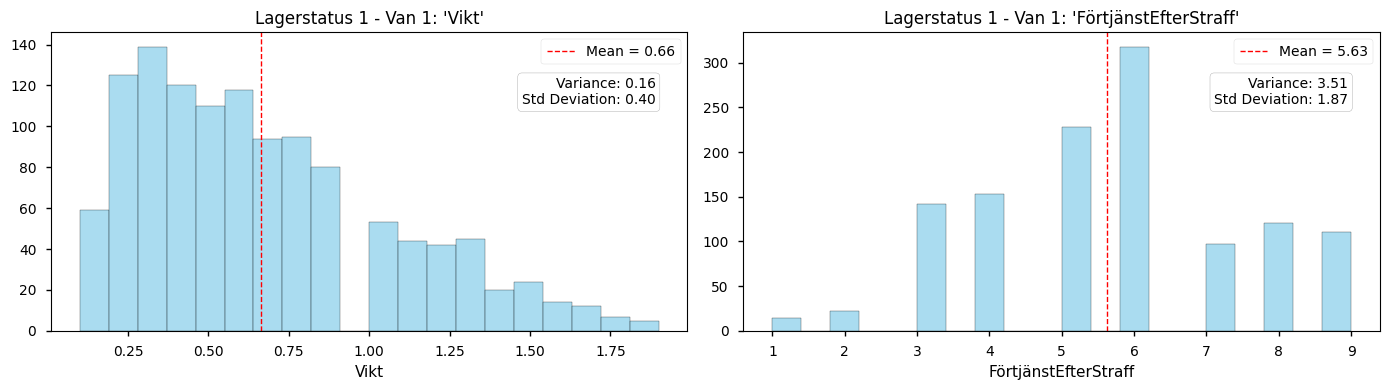

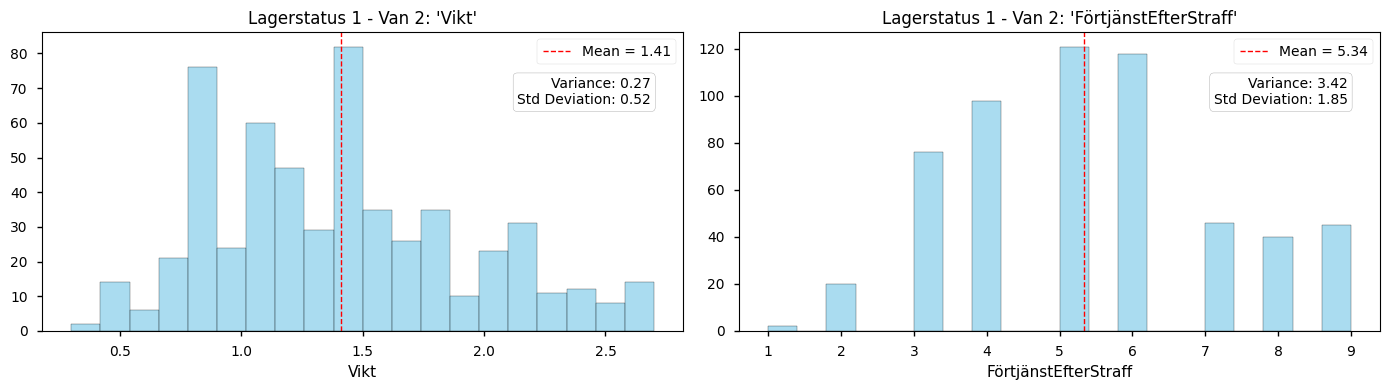

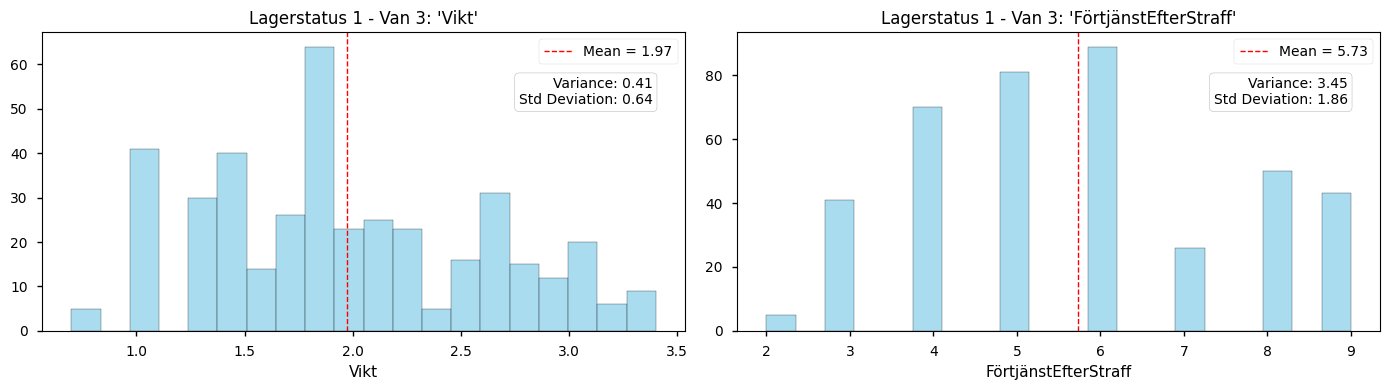

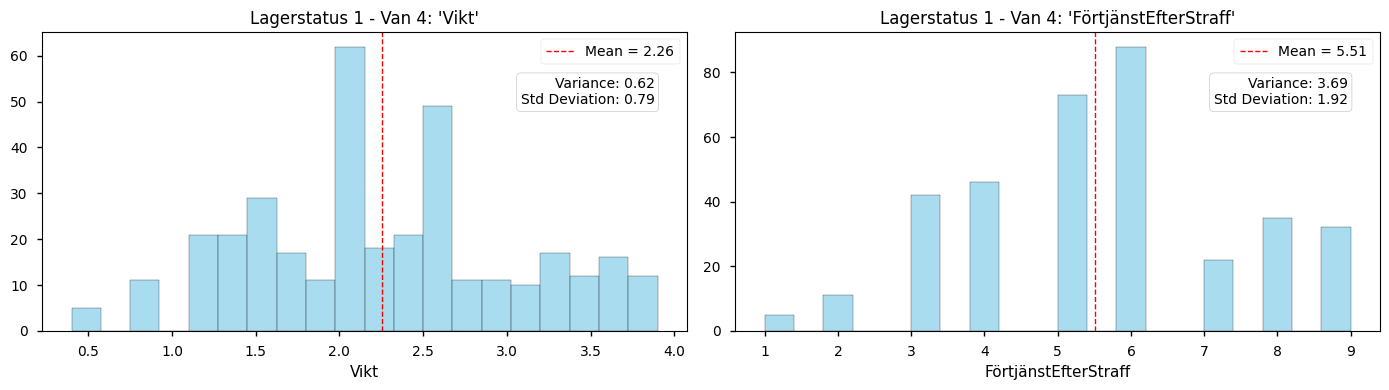

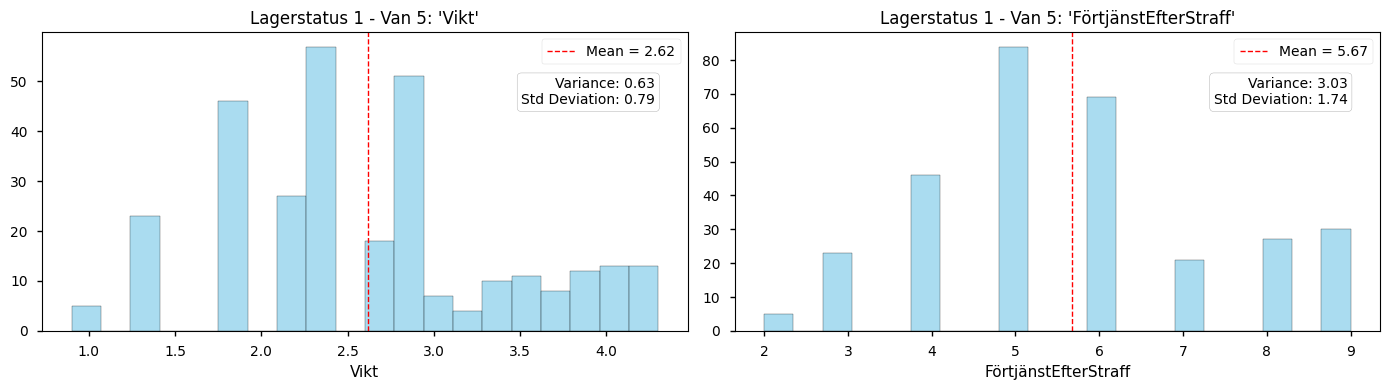

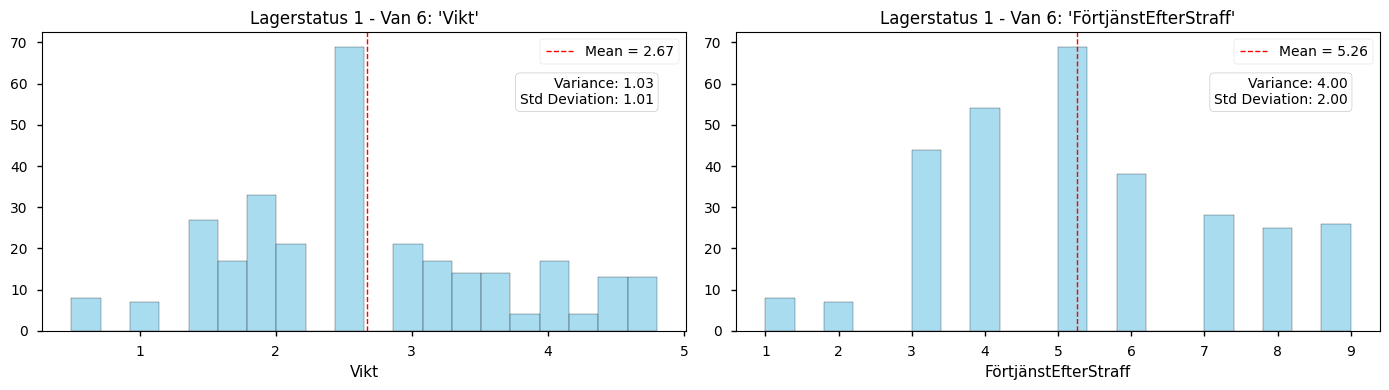

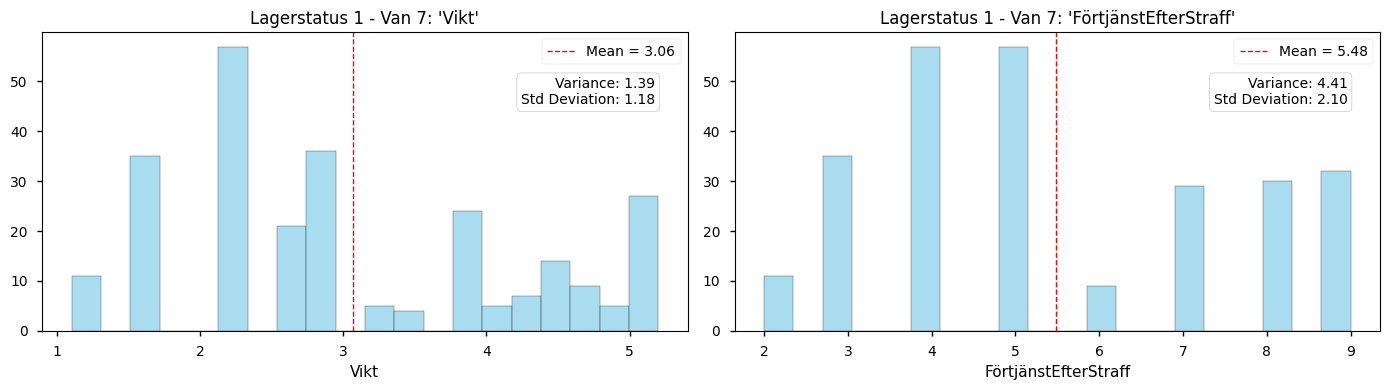

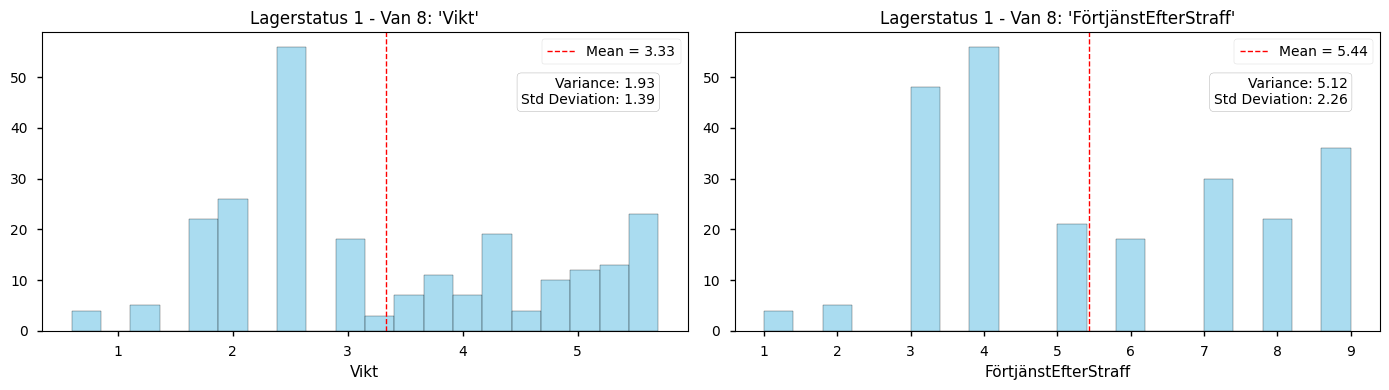

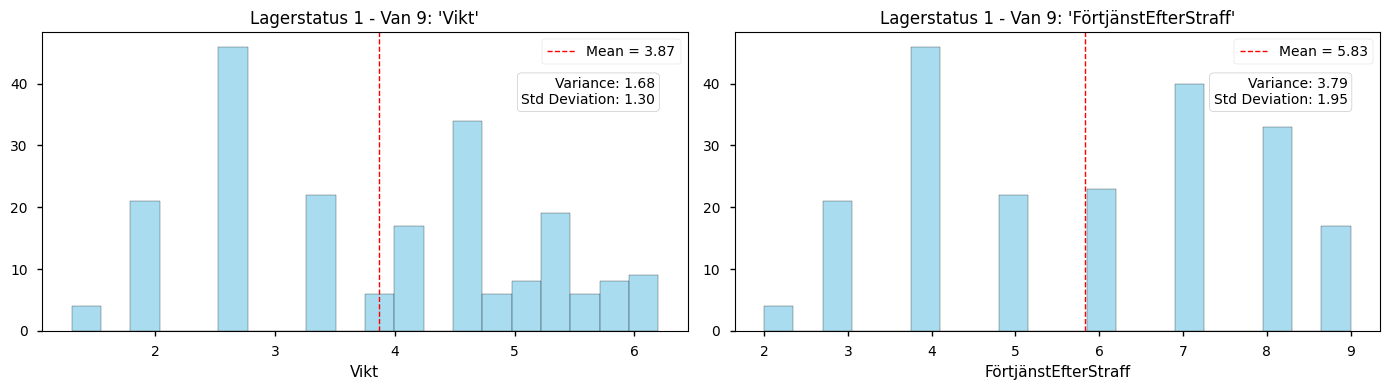

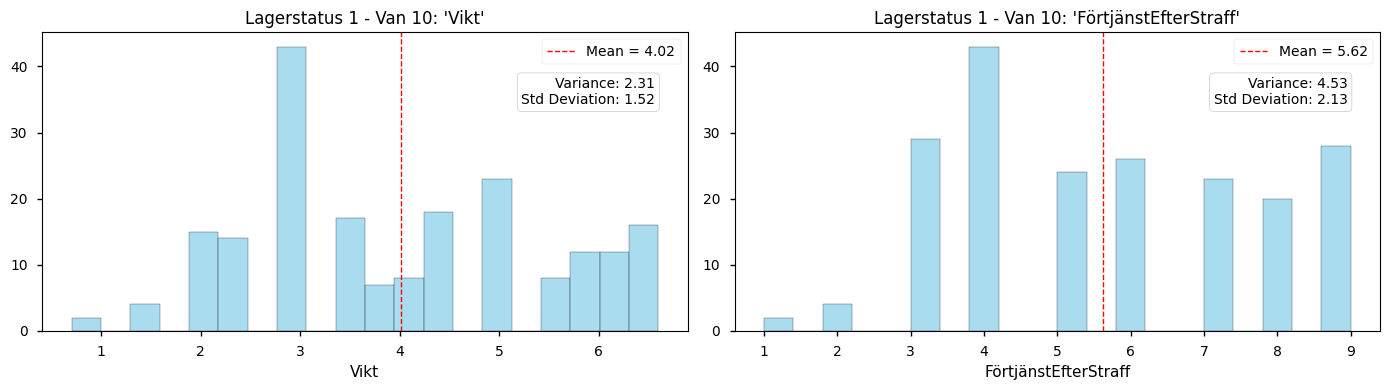

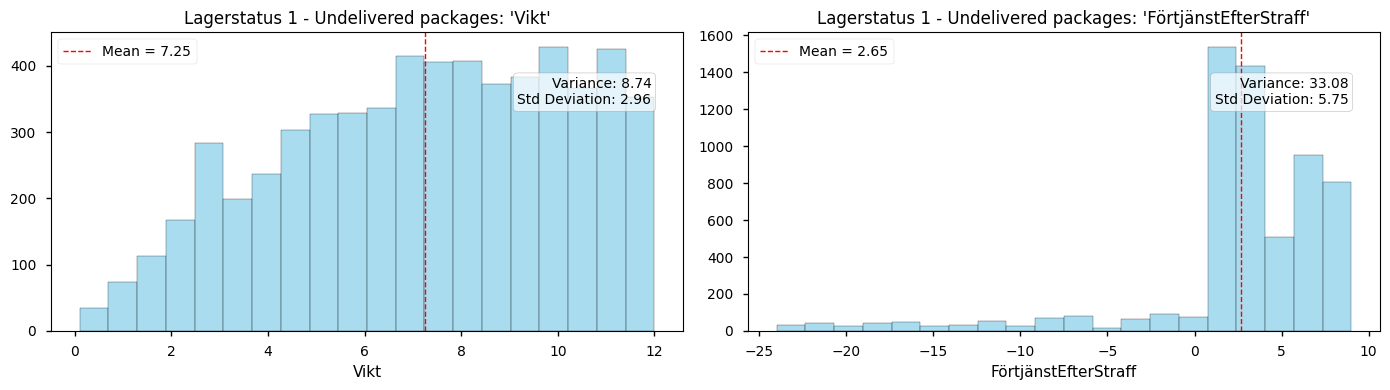

- Lagerstatus 2 -
Total förtjänst: 24358.0
Ökad förtjänst efter optimering: 0.0
Paket kvar i lager: 5455
Total straffavgift för paket kvar i lager: 5226
Total förtjänst för paket kvar i lager (exklusive straff): 23899


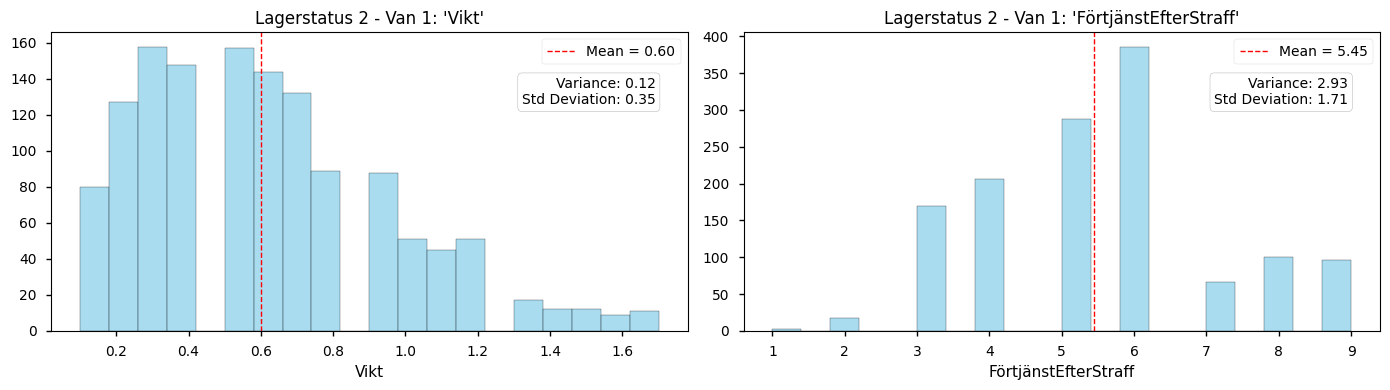

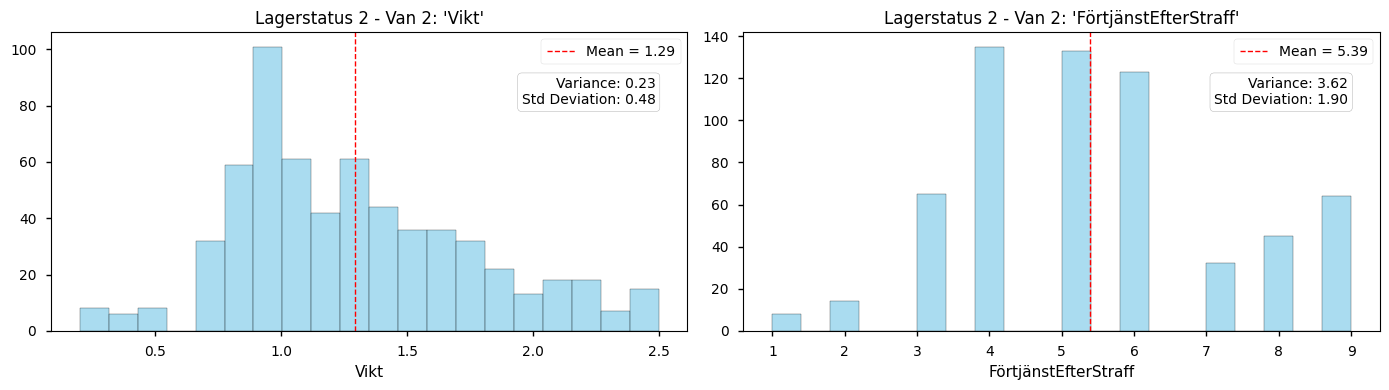

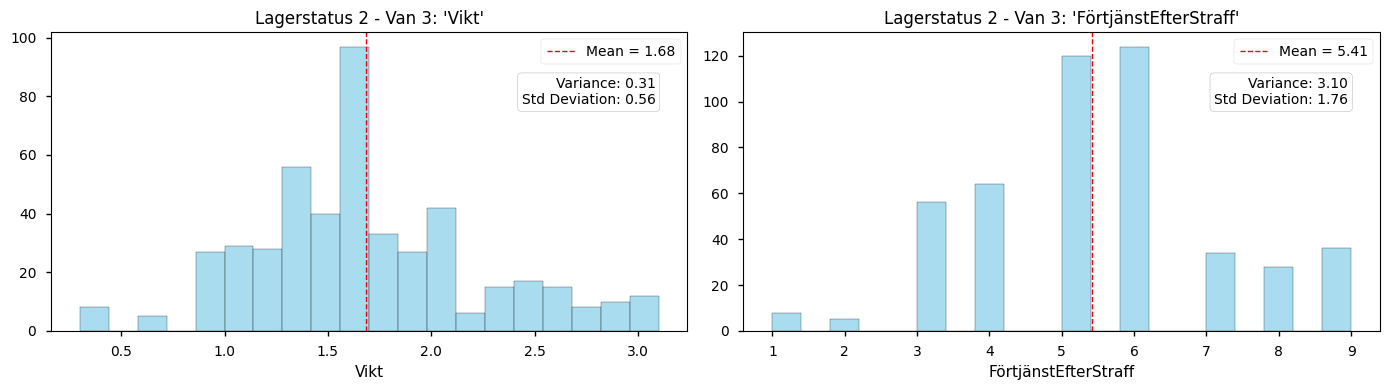

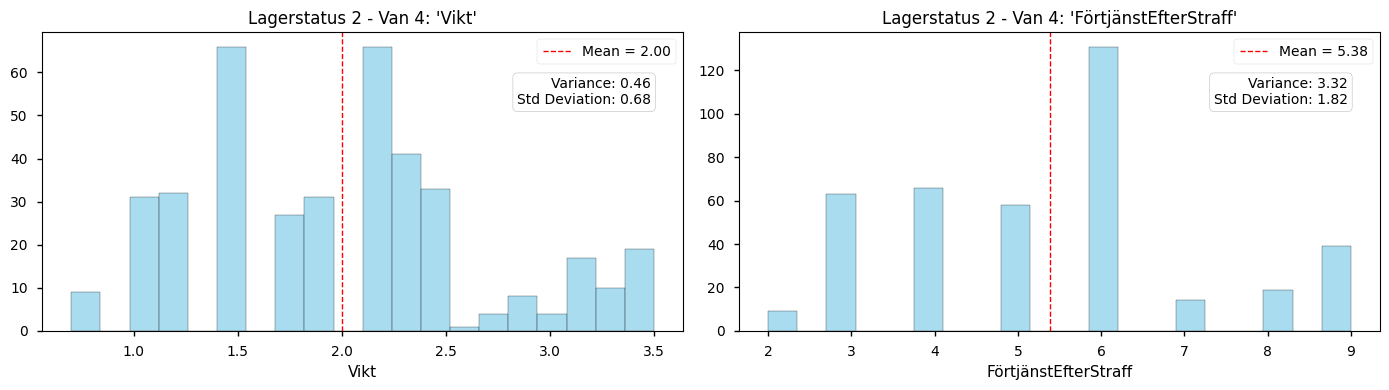

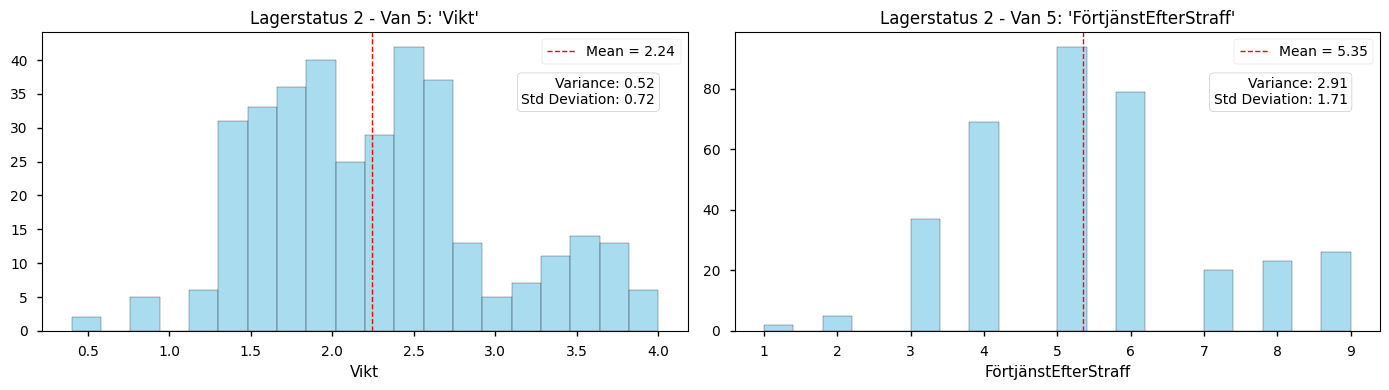

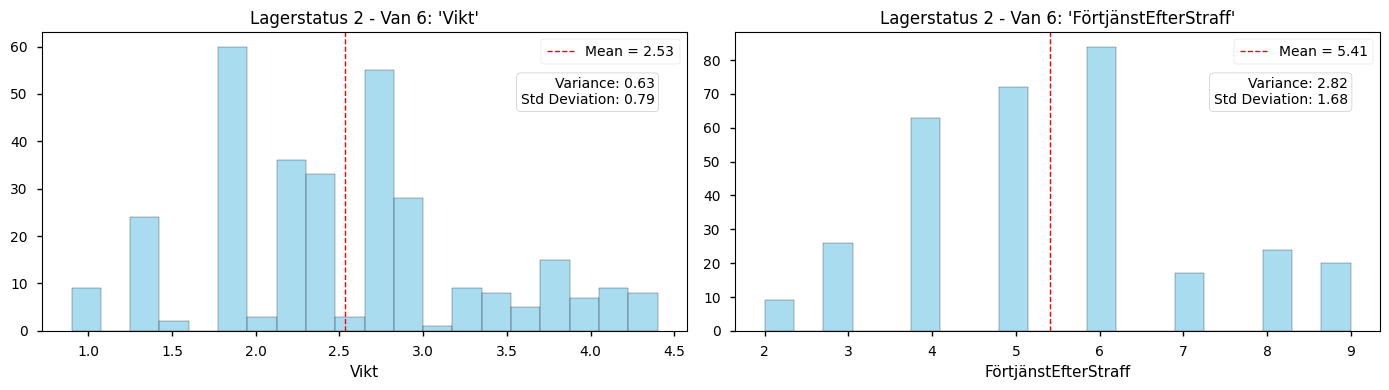

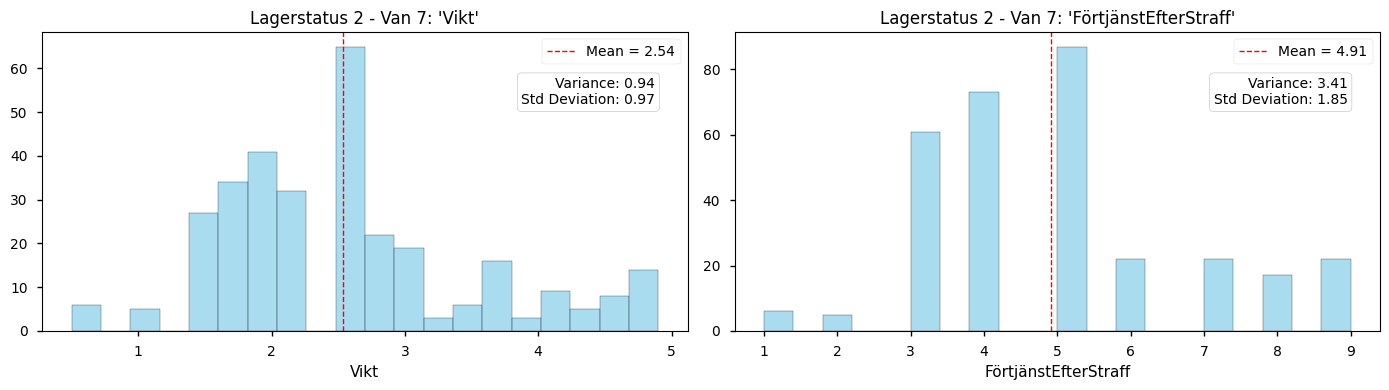

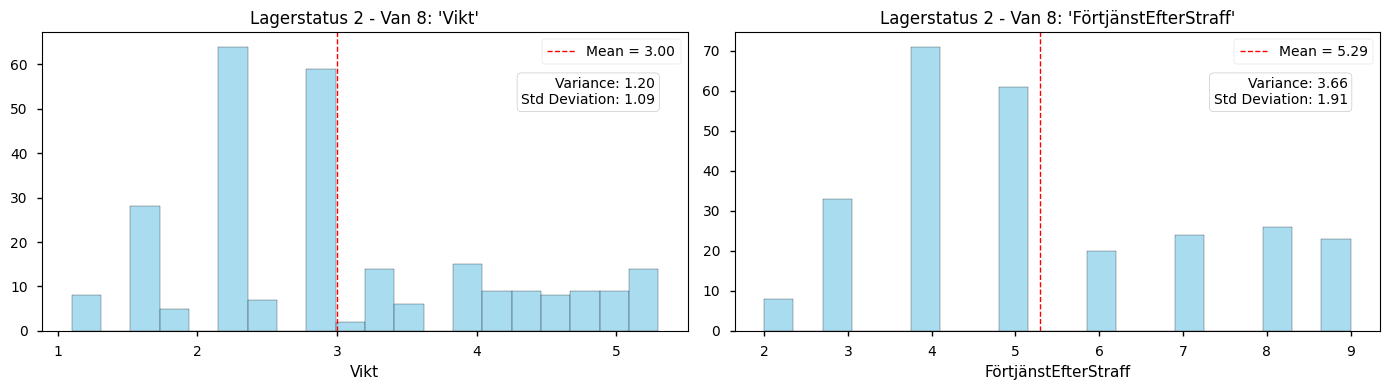

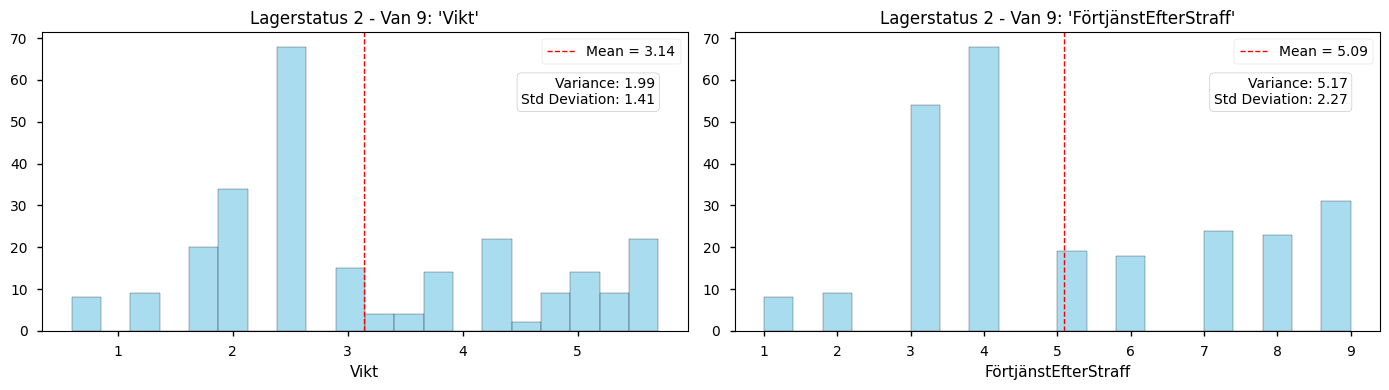

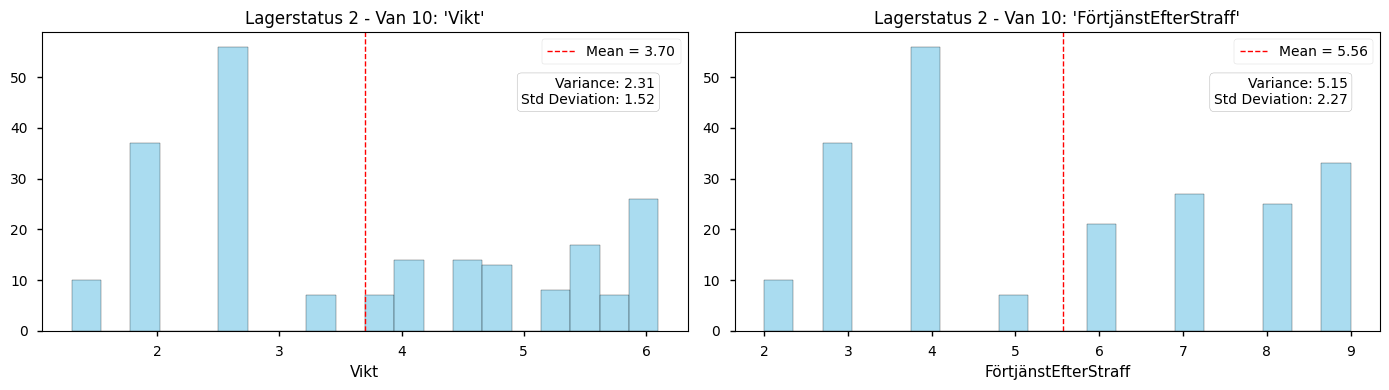

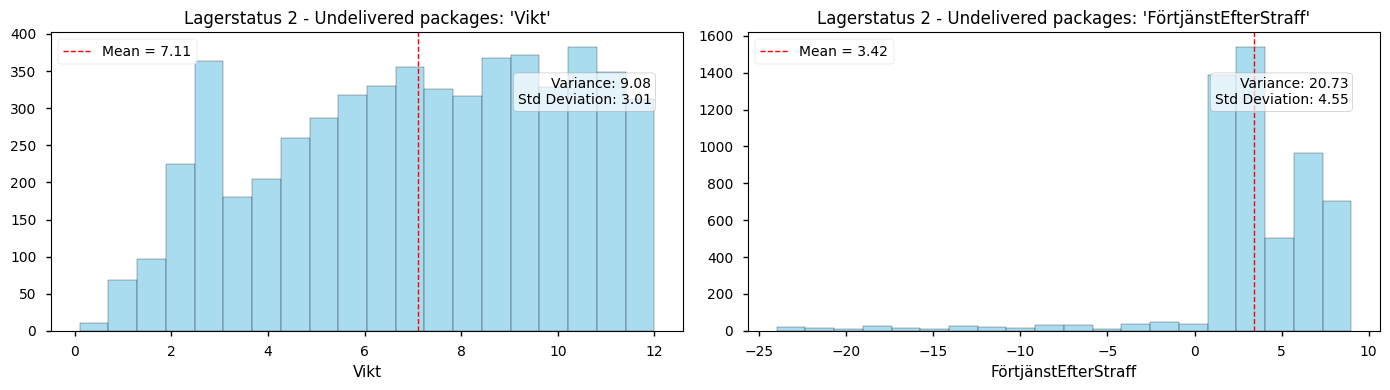

- Lagerstatus 3 -
Total förtjänst: 20974.0
Ökad förtjänst efter optimering: -8.0
Paket kvar i lager: 6589
Total straffavgift för paket kvar i lager: 5228
Total förtjänst för paket kvar i lager (exklusive straff): 29096


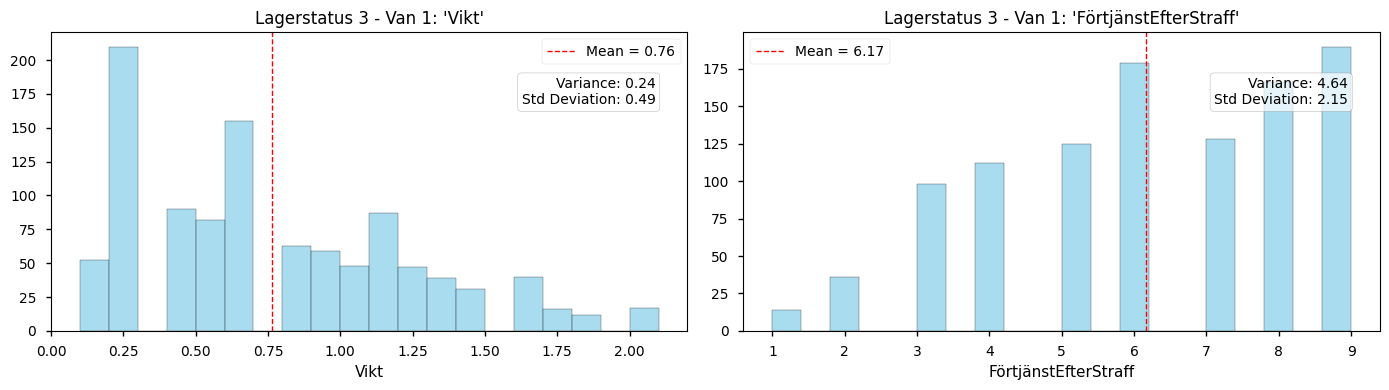

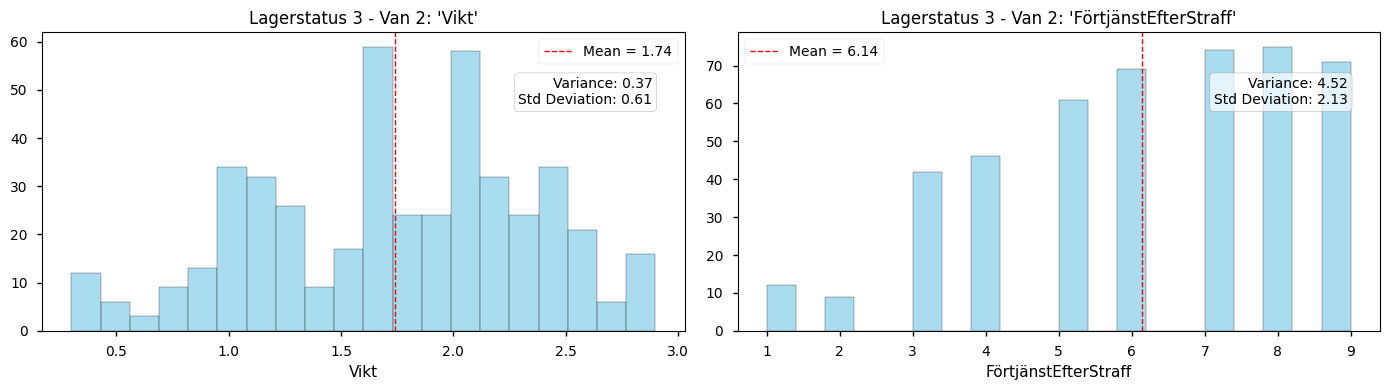

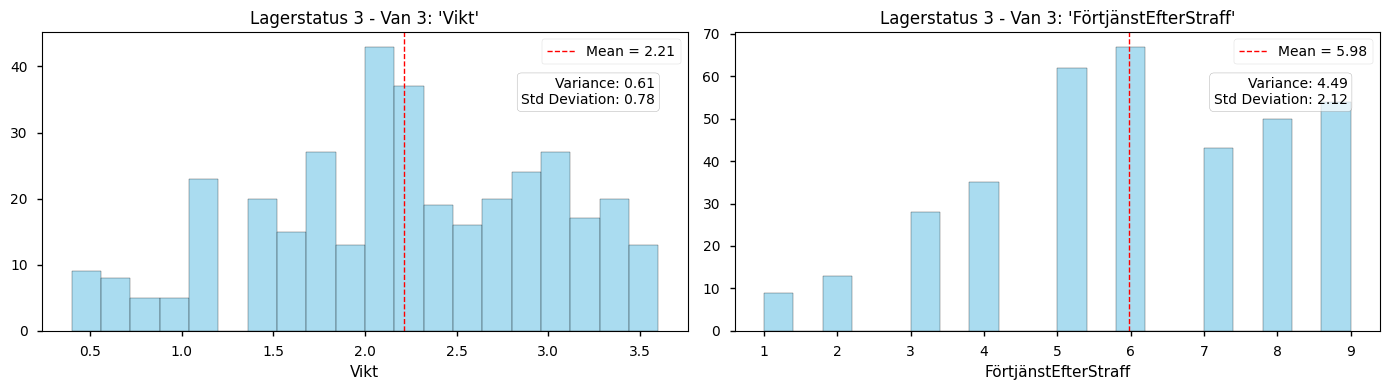

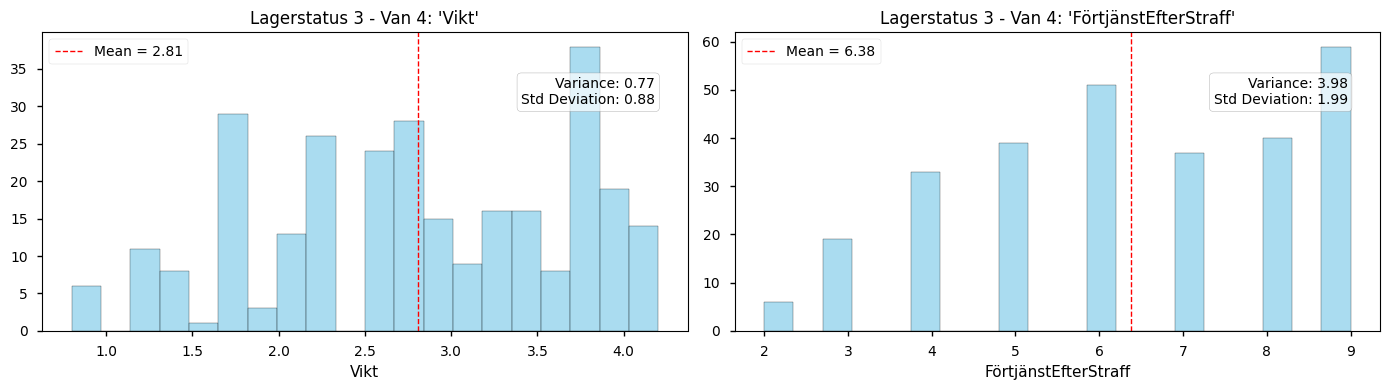

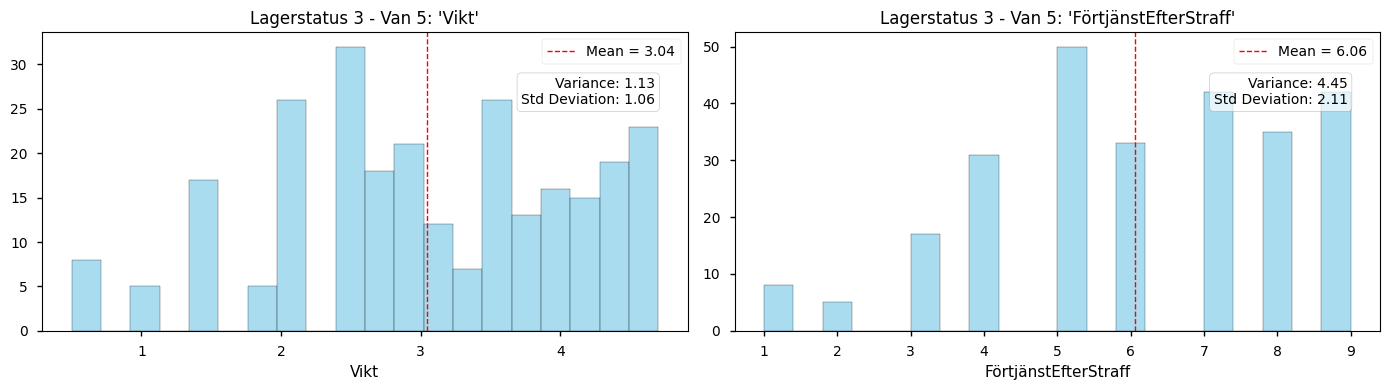

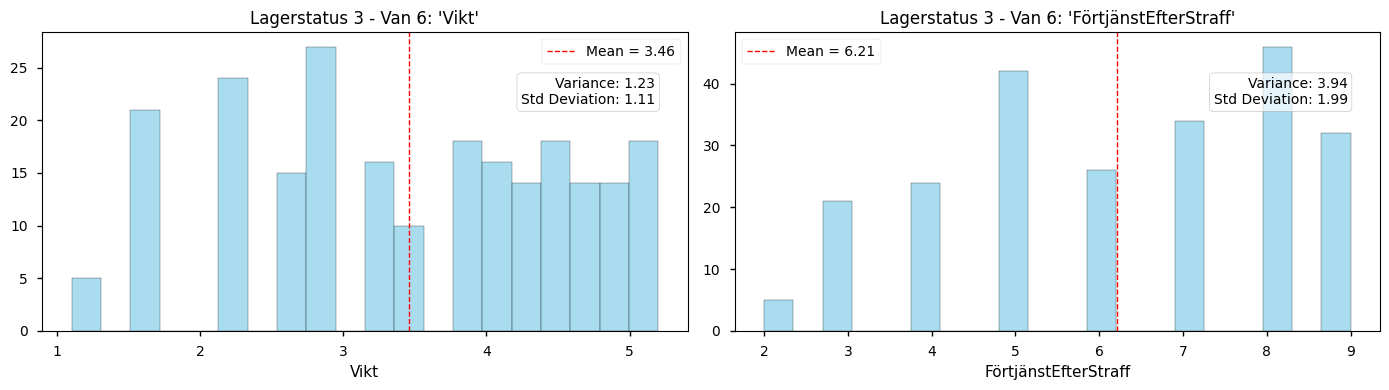

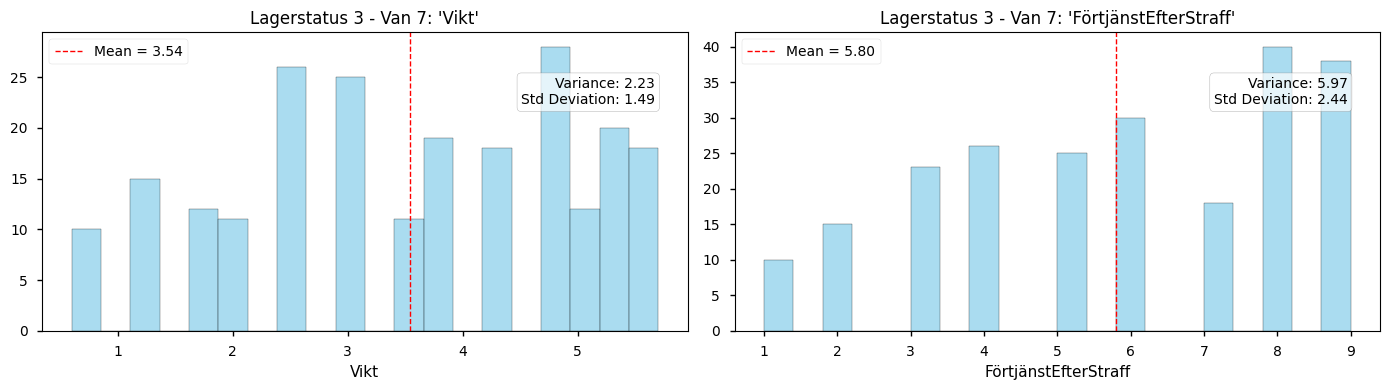

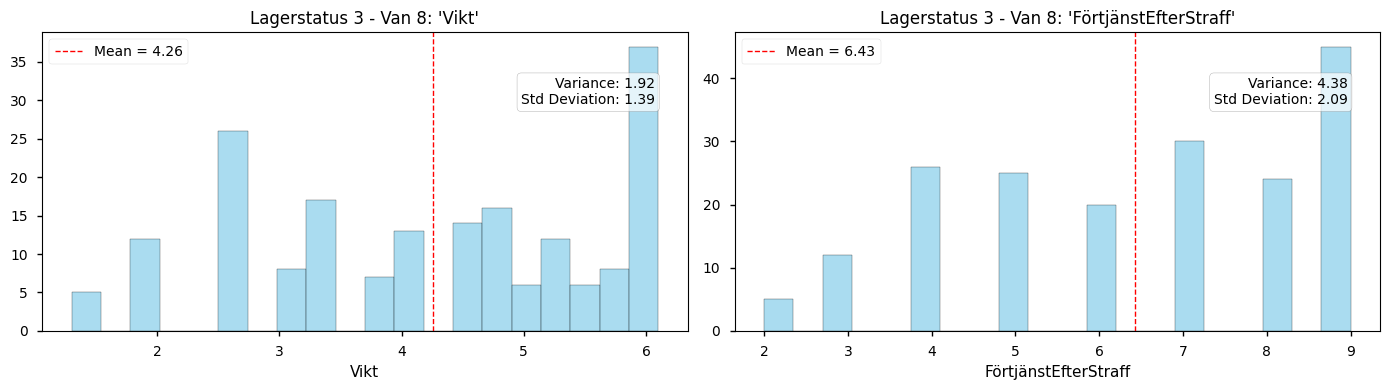

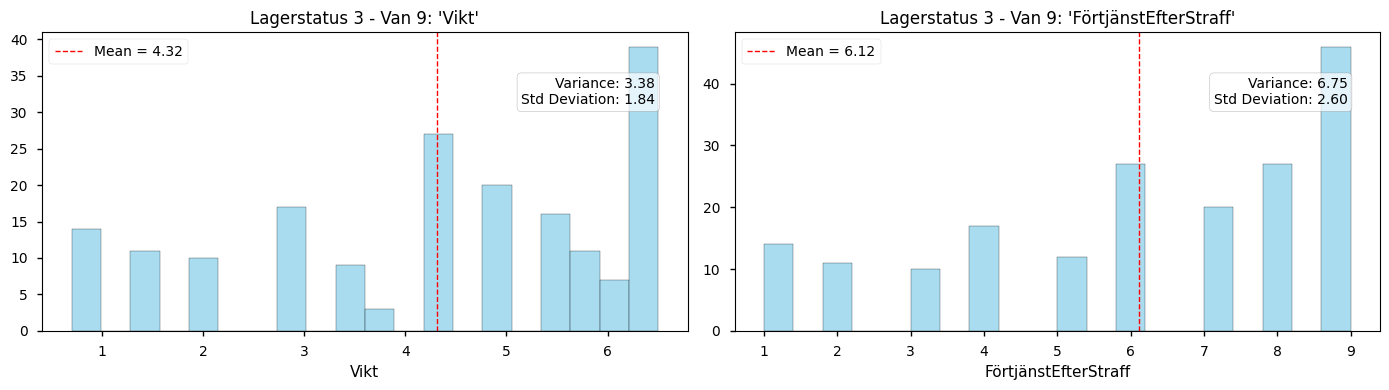

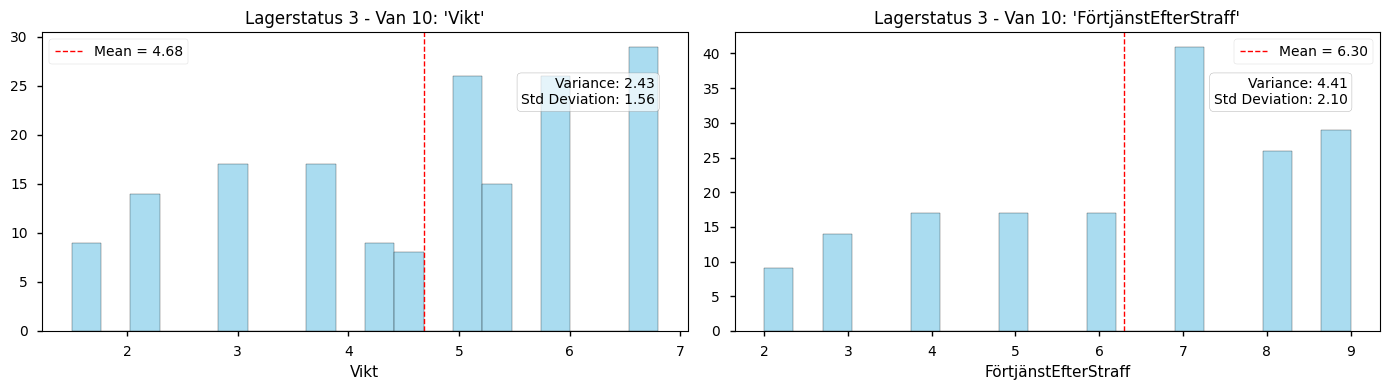

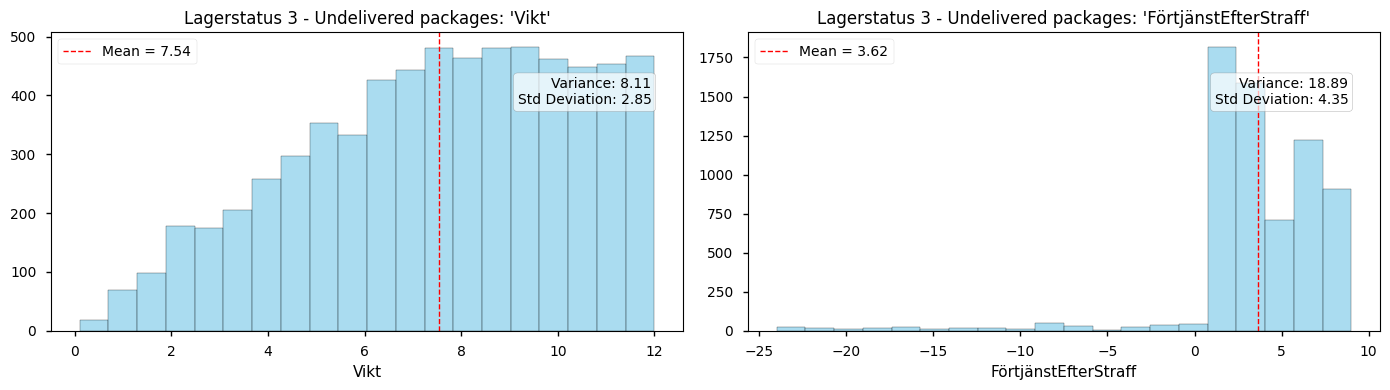

- Lagerstatus 4 -
Total förtjänst: 18858.0
Ökad förtjänst efter optimering: 2.0
Paket kvar i lager: 6879
Total straffavgift för paket kvar i lager: 27358
Total förtjänst för paket kvar i lager (exklusive straff): 30460


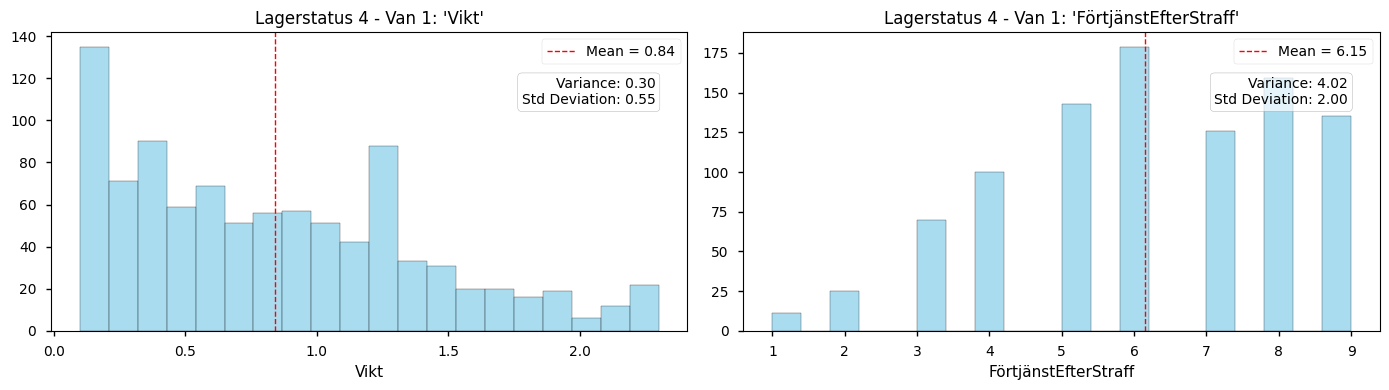

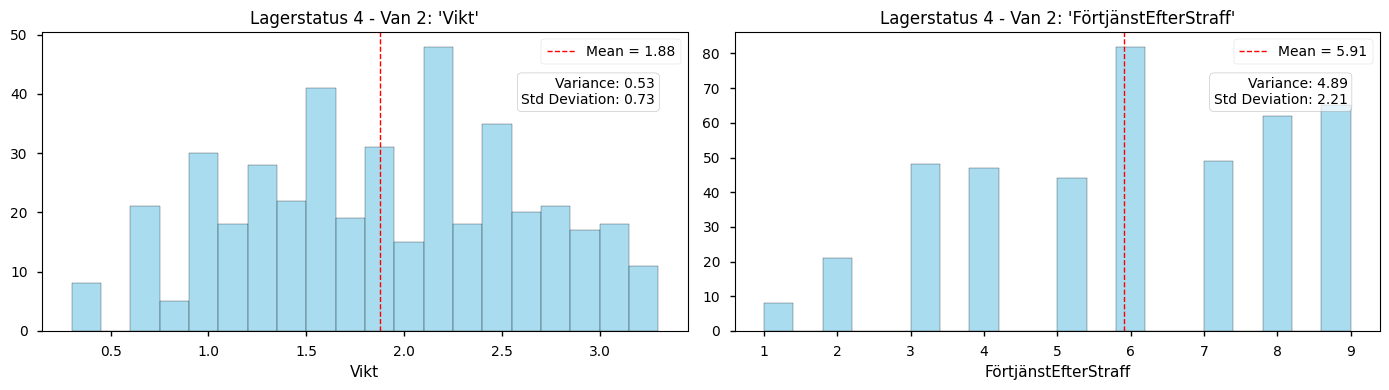

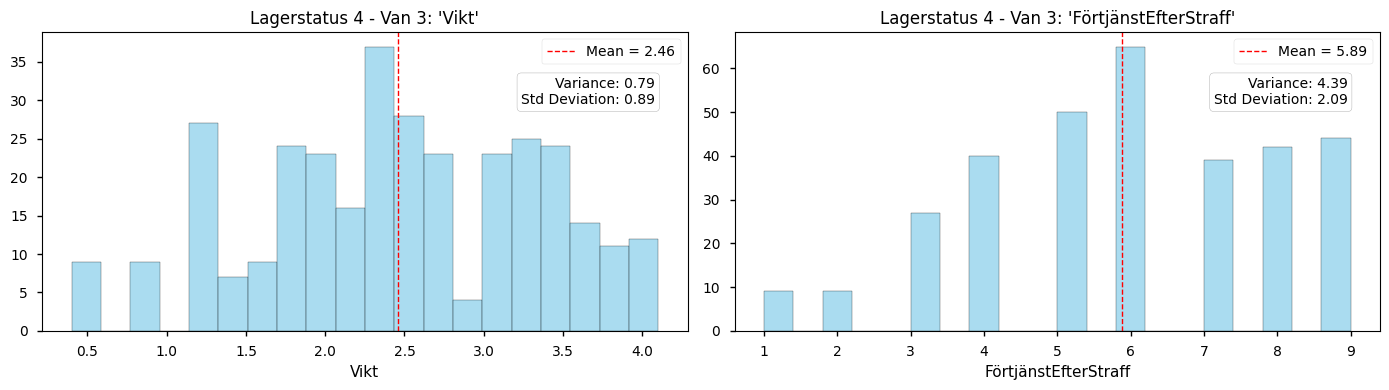

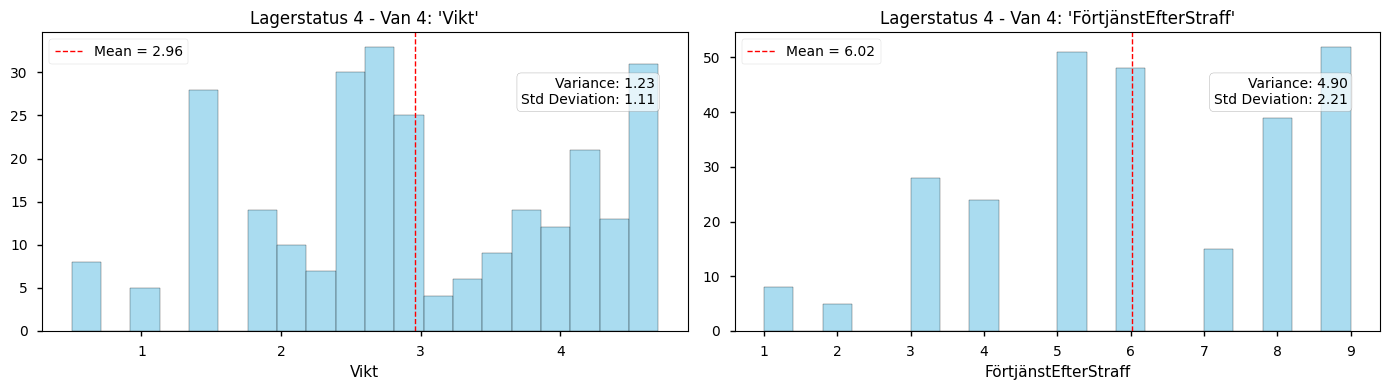

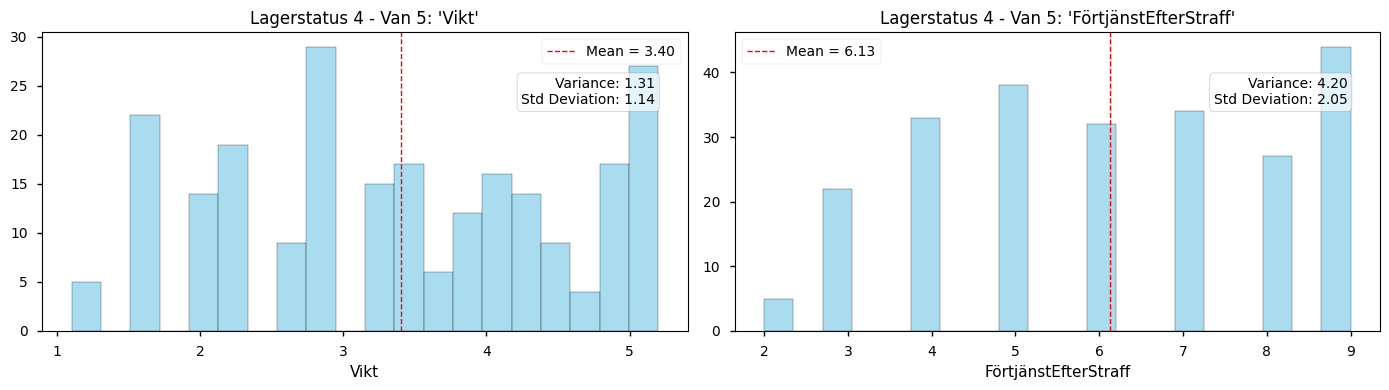

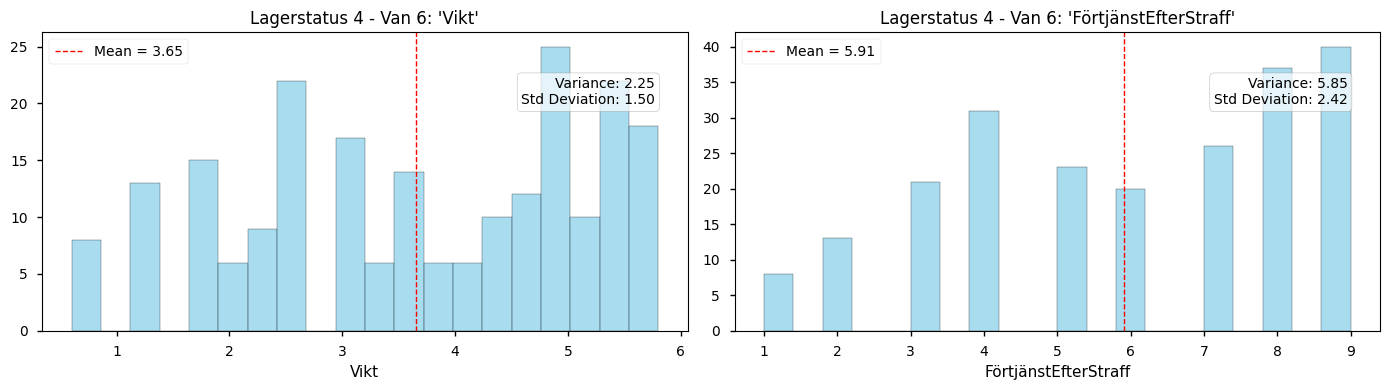

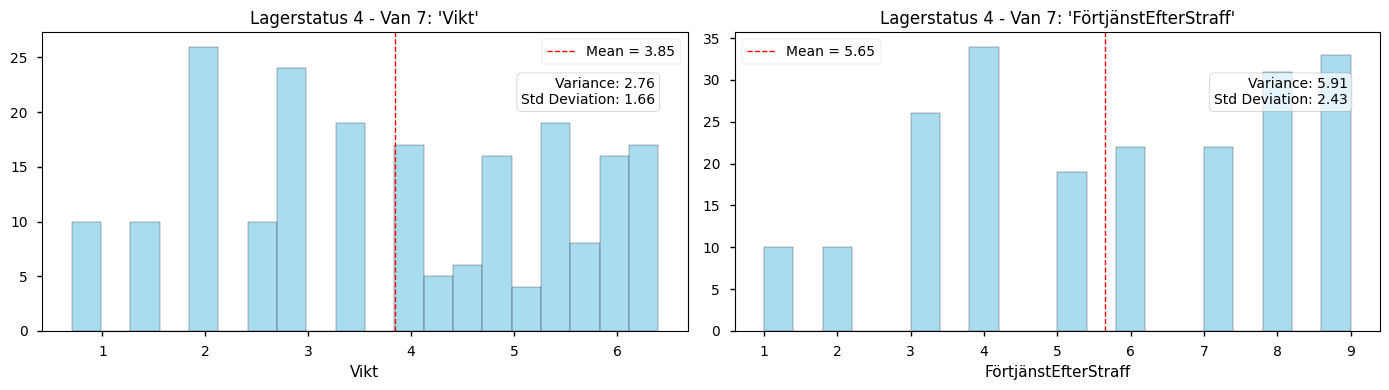

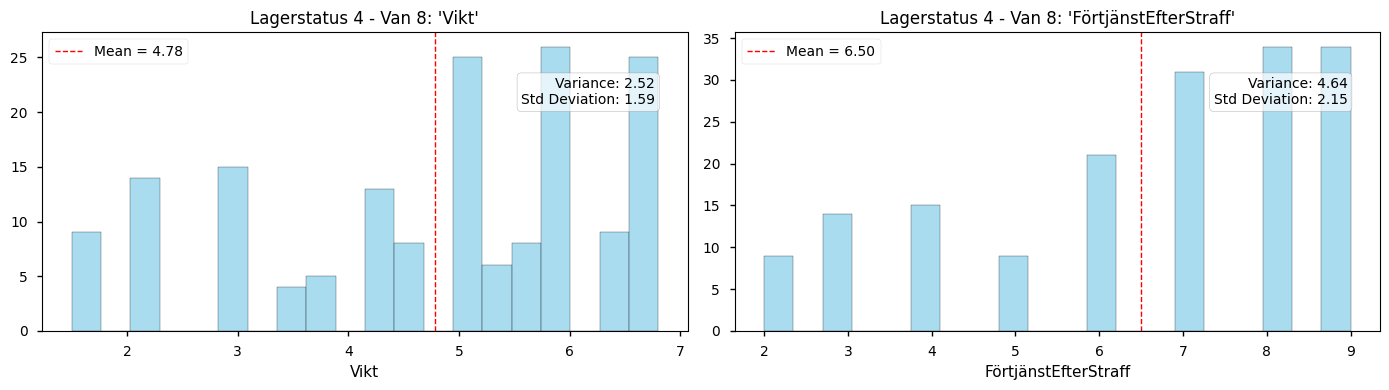

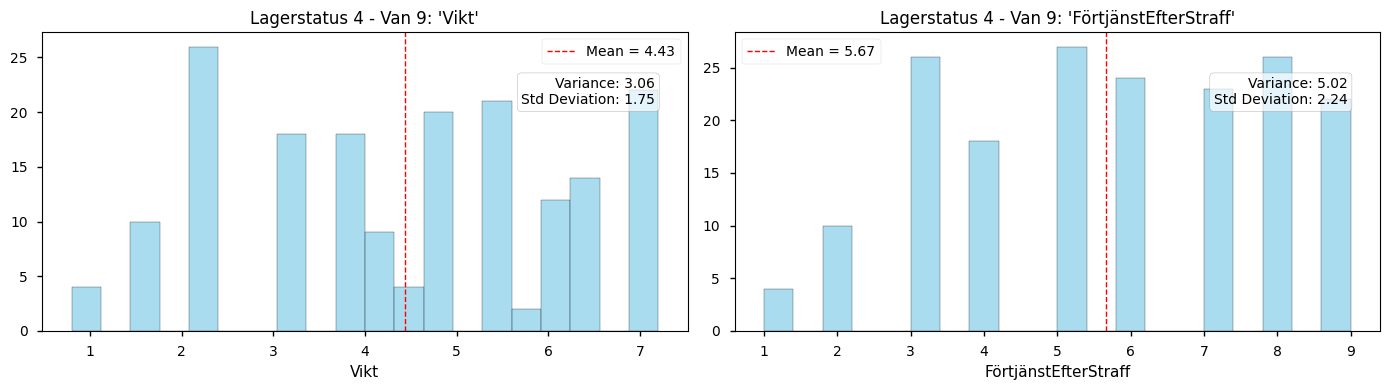

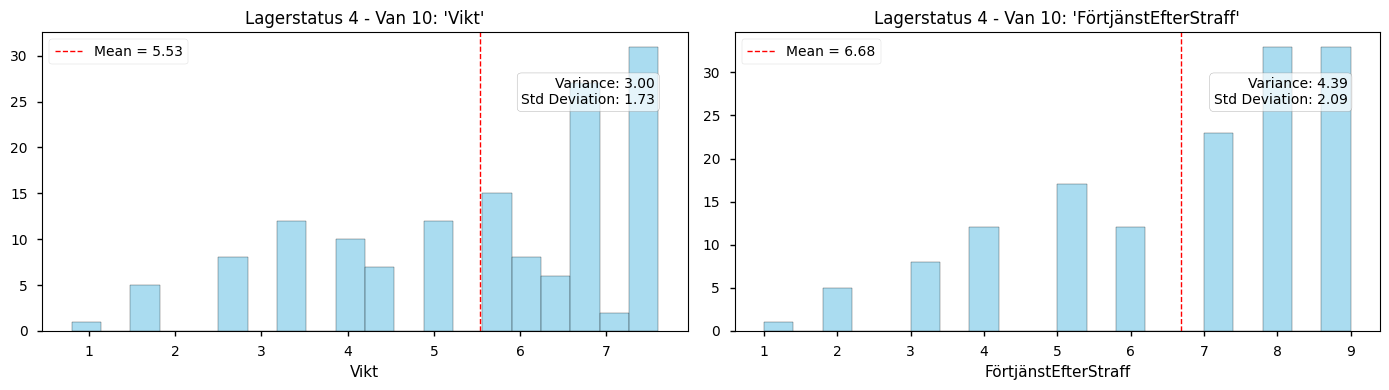

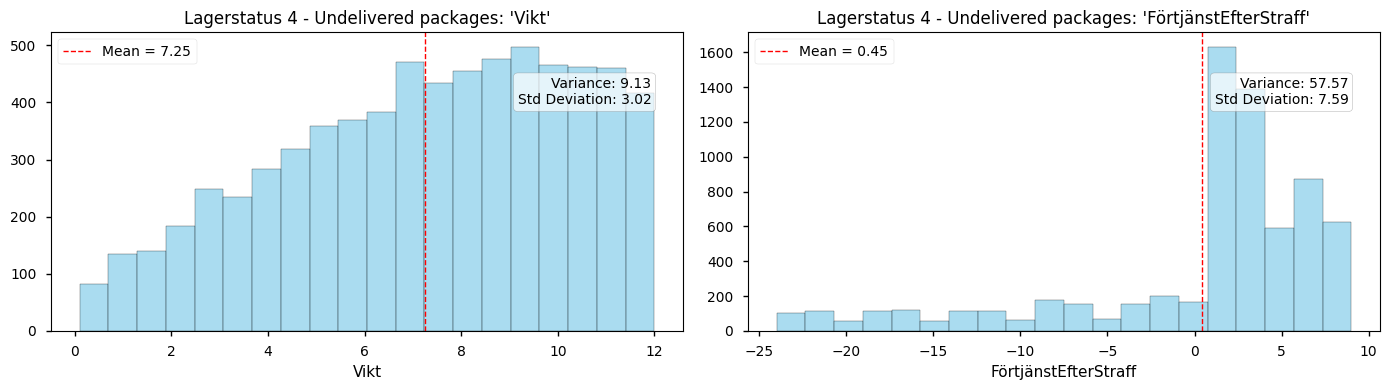

In [11]:
for lagerstatus_nr, lagerstatus in enumerate( [packages1, packages2, packages3, packages4], start=1 ):
    result = main.package_vans(N_PACKAGES, lagerstatus)
    lagerstatus_packaged = result["df"]
    
    print(f"- Lagerstatus {lagerstatus_nr} -")
    print("Total förtjänst:", result["profit"])
    print("Ökad förtjänst efter optimering:", result["profit_gain"])
    print("Paket kvar i lager:", (lagerstatus_packaged['Delivered'] == VanNumber.NOT_DELIVERED).sum())
    print("Total straffavgift för paket kvar i lager:", result["penalty_of_undelivered_packages"])
    print("Total förtjänst för paket kvar i lager (exklusive straff):", result["profit_of_undelivered_packages"])

    for van_number in VanNumber:
        if van_number > VanNumber.NOT_DELIVERED:
            plot_packages( get_packages(lagerstatus_packaged, van_number), f"Lagerstatus {lagerstatus_nr} - Van {van_number+1}" )
    plot_packages( get_packages(lagerstatus_packaged, VanNumber.NOT_DELIVERED), f"Lagerstatus {lagerstatus_nr} - Undelivered packages" )

# Results
Lagerstatus 1 and 2 saw no increased profits after optimization. Lagerstatus 3 saw a slight decrease in profit. Lagerstatus 4 however, saw a tiny increase in profit.